In [1]:
# Config parameters
deepmd_jax_path = '../'           # Path to deepmd_jax package; change if you run this script at a different directory
precision       = 'default'       # 'default'(fp32), 'low'(mixed 32-16), 'high'(fp64)
save_name       = 'trained_models/new_dpmp_water32.pkl' # model save path
model_type      = 'energy'        # 'energy' or 'atomic' (e.g. wannier)
atomic_sel      = [0]             # select atom type for prediction (only for 'atomic' model)
atomic_label    = 'atomic_dipole' # data file prefix for 'atomic' model; string must contain 'atomic'

# Dataset in DeepMD-kit format; nested paths like [[dat1,dat2],[dat3]] allowed
# Note: Here the atomic type index of dat1,dat2 must be the same, but that of dat3 can be different
# train_paths     = ['data/chunyi_dplr/data/dipole_data']
train_paths     = ['data/water_128_shifted/']
# train_paths     = ['data/chunyi_dplr/data/energy_force_data/data_sr']
# train_paths     = ['data/chunyi_dplr/data/energy_force_data/data/data' + str(i) for i in range(1,46)] \
#                    + ['data/chunyi_dplr/data/energy_force_data/data/data_ex' + str(i) for i in range(1,7)]
use_val_data    = False           # if not, next line is ignored
val_paths       = ['/pscratch/sd/r/ruiqig/polaron_cp2k/aimd/polaron_full_val']

# Model parameters
rcut            = 6.0             # cutoff radius (Angstrom)
use_2nd_tensor  = True            # Use 2nd order tensor descriptor for more accuracy, slightly slower
use_mp          = True            # Use message passing (DP-MP) model for even more accuracy (slower) 
compress        = False            # Compress model after training for faster inference. Rec: True  
embed_widths    = [32,32,64]      # Rec: [32,32,64] (for accuracy try [48,48,96])
embedMP_widths  = [32,64]         # Rec: [32,64]; Only used in MP; (Try [64,64] or [96,96] according to embed_widths)
fit_widths      = [64,64,64]      # For 'atomic' model, fit_widths[-1] must equal embed_widths[-1](DP)/embedMP_widths[-1](DP-MP)
axis_neurons    = 12              # Rec: 8-16

# Training parameters
batch_size      = 1               # training batch size; Rec: 128 <= labels_per_frame*batch_size <= 512
val_batch_size  = 8               # validation batch size. Too much can cause OOM error.
lr              = 0.002           # learning rate at start. Rec: 0.001/0.002 for 'energy', 0.01 for 'atomic'
s_pref_e        = 0.02            # starting prefactor for energy loss
l_pref_e        = 1               # limit prefactor for energy loss, increase for energy accuracy
s_pref_f        = 1000            # starting prefactor for force loss
l_pref_f        = 1               # limit prefactor for force loss, increase for force accuracy
total_steps     = 200000          # total training steps. Rec: 1e6 for 'energy', 1e5 for 'atomic'
print_every     = 1000            # for printing loss and validation

# parameters you usually don't need to change
lr_limit        = 5e-7            # learning rate at end of training
compress_Ngrids = 512             # Number of intervals used in compression
compress_rmin   = 0.6             # Lower bound for interatomic distance in compression
beta2           = 0.99            # adam optimizer parameter
l_smoothing     = 20              # smoothing factor for loss printing
decay_steps     = 5000            # learning rate exponentially decays every decay_steps
getstat_bs      = 64              # batch size for computing model statistics at initialization

# From here on you don't need to change anything unless you know what you are doing
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import numpy as np
from jax import jit, random, tree_util
import jax, optax, sys, os, datetime
import flax.linen as nn
from time import time
from functools import partial
sys.path.append(os.path.abspath(deepmd_jax_path))
from deepmd_jax import data, utils
from deepmd_jax.dpmodel import DPModel, compress_model
if precision == 'default':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == 'high':
    jax.config.update('jax_enable_x64', True)
TIC = time()
print('# Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])

labels = ['coord','box'] + (['force','energy'] if model_type == 'energy' else [atomic_label])
train_data     = data.DPDataset(train_paths, labels, {'atomic_sel':atomic_sel})
val_data       = data.DPDataset(val_paths, labels, {'atomic_sel':atomic_sel}) if use_val_data else None
model = DPModel({'embed_widths':embed_widths[:-1] if use_mp else embed_widths,
                 'embedMP_widths':embed_widths[-1:] + embedMP_widths if use_mp else None,
                 'fit_widths':fit_widths,
                 'axis':axis_neurons,
                 'Ebias':train_data.fit_energy() if model_type == 'energy' else None,
                 'rcut':rcut,
                 'use_2nd':use_2nd_tensor,
                 'use_mp':use_mp,
                 'atomic':True if model_type == 'atomic' else False,
                 'nsel':atomic_sel if model_type == 'atomic' else None,
                 'out_norm': 1. if model_type == 'energy' else train_data.get_atomic_label_scale()})
train_data.compute_lattice_candidate(rcut)
if use_val_data:
    val_data.compute_lattice_candidate(rcut)
batch, type_count, lattice_args = train_data.get_batch(getstat_bs)
static_args         = nn.FrozenDict({'type_count':type_count, 'lattice':lattice_args})
model.get_stats(batch['coord'], batch['box'], static_args)
print('# Model params:', model.params)
variables           = model.init(random.PRNGKey(np.random.randint(42)), batch['coord'][0], batch['box'][0], static_args)
print('# Model initialized. Precision: %s. Parameter count: %d.' % 
            ({'default': 'fp32', 'low': 'fp32-16', 'high': 'fp64'}[precision], 
            sum(i.size for i in tree_util.tree_flatten(variables)[0])))
lr_scheduler        = optax.exponential_decay(init_value=lr, transition_steps=decay_steps,
                        decay_rate=(lr_limit/lr)**(decay_steps/(total_steps-decay_steps)), transition_begin=0, staircase=True)
optimizer           = optax.adam(learning_rate=lr_scheduler, b2=beta2)
opt_state           = optimizer.init(variables)
loss, loss_and_grad = model.get_loss_fn()
print('# Optimizer initialized, lr starts from %.1e. Starting training...' % lr)

state = {'loss_avg':0., 'iteration':0} | ({} if model_type == 'atomic' else {'le_avg':0., 'lf_avg':0.})
@partial(jit, static_argnums=(4,))
def train_step(batch, variables, opt_state, state, static_args):
    r = lr_scheduler(state['iteration']) / lr
    if model_type == 'energy':
        pref = {'e': s_pref_e*r + l_pref_e*(1-r), 'f': s_pref_f*r + l_pref_f*(1-r)}
        (loss_total, (loss_e, loss_f)), grads = loss_and_grad(variables, batch, pref, static_args)
        for key, value in zip(['loss_avg', 'le_avg', 'lf_avg'], [loss_total, loss_e, loss_f]):
            state[key] = state[key] * (1-1/l_smoothing) + value
    else:
        loss_total, grads = loss_and_grad(variables, batch, static_args)
        state['loss_avg'] = state['loss_avg'] * (1-1/l_smoothing) + loss_total
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    state['iteration'] += 1
    return variables, opt_state, state

@partial(jit, static_argnums=(2,))
def val_step(batch, variables, static_args):
    if model_type == 'energy':
        pref = {'e': 1, 'f': 1}
        _, (loss_e, loss_f) = loss(variables, batch, pref, static_args)
        return loss_e, loss_f
    else:
        loss_total = loss(variables, batch, static_args)
        return loss_total

tic = time()
for iteration in range(total_steps+1):
    batch, type_count, lattice_args = train_data.get_batch(batch_size)
    static_args = nn.FrozenDict({'type_count':tuple(type_count), 'lattice':lattice_args})
    variables, opt_state, state = train_step(batch, variables, opt_state, state, static_args)
    if iteration % print_every == 0:
        if use_val_data:
            val_batch, type_count, lattice_args = val_data.get_batch(val_batch_size)
            static_args = nn.FrozenDict({'type_count':tuple(type_count), 'lattice':lattice_args})
            loss_val = val_step(val_batch, variables, static_args)
        beta = l_smoothing * (1 - (1/l_smoothing)**(iteration+1))
        print('Iter %7d' % iteration
              + ' L %7.5f' % (state['loss_avg']/beta)**0.5
              + (' LE %7.5f' % (state['le_avg']/beta)**0.5 if model_type == 'energy' else '')
              + (' LF %7.5f' % (state['lf_avg']/beta)**0.5 if model_type == 'energy' else '')
              + (' LEval %7.5f' % loss_val[0]**0.5 if model_type == 'energy' and use_val_data else '')
              + (' LFval %7.5f' % loss_val[1]**0.5 if model_type == 'energy' and use_val_data else '')
              + (' Lval %7.5f' % loss_val**0.5 if model_type == 'atomic' and use_val_data else '')
              + ' Time %.2fs' % (time()-tic))
        tic = time()
if compress:
    model, variables = utils.compress_model(model, variables, compress_Ngrids, compress_rmin)
utils.save_model(save_name, model, variables)
T = int(time() - TIC)
print('# Training finished in %dh %dm %ds.' % (T//3600,(T%3600)//60,T%60))

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
# Program start at 2023-11-21 16:00:19 on device: [cuda(id=0)]
# Dataset loaded: 7797 frames/384 atoms. Path: 
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/water_128_shifted'
# Lattice vectors for neighbor images: Max 1 out of 1 condidates.
# Model params: {'embed_widths': [32, 32], 'embedMP_widths': [64, 32, 64], 'fit_widths': [64, 64, 64], 'axis': 12, 'Ebias': array([ -93.55532, -187.11064], dtype=float32), 'rcut': 6.0, 'use_2nd': True, 'use_mp': True, 'atomic': False, 'nsel': None, 'out_norm': 1.0, 'sr_mean': [Array(0.07398456, dtype=float32), Array(0.06992824, dtype=float32)], 'sr_std': [Array(0.15338491, dtype=float32), Array(0.13181955, dtype=float32)], 'Nnbrs': Array(90.639206, dtype=float32)}
# Model initialized. Precision: fp32. Parameter count: 232274.
# Optimizer initialized, lr starts from 2.0e-03. Starting training...
Iter       0 L 5.88560 LE 0.03687 LF 0.18612 Time 16.70s
Iter    1000 L 2.57296 LE 0.01439 LF 0.08136 Time 25.53

In [18]:
K = 512
model, variables = utils.compress_model(model, variables, K, compress_rmin)
utils.save_model('trained_models/new_dpmp_water32_%d.pkl' % K, model, variables)

# Model Compressed: 12 embedding nets, 512 intervals
# Compression (0,1,2)-order error: Mean = (5.89e-10,-3.66e-09,4.55e-09), Max = (1.85e-06,3.33e-04,9.86e-02)
# Model saved to 'trained_models/new_dpmp_water32_512.pkl'.


In [6]:
variables['params']['embedding_net_2']

{'Dense_0': {'bias': Array([-0.8396764 , -1.0154009 , -1.691621  , -1.4928366 , -0.99803644,
         -0.3937565 ,  1.4541517 , -1.4609375 ,  0.09648626,  0.48089167,
         -0.8094328 , -0.00937582,  0.5898745 , -0.44914672, -0.21979809,
         -1.3450179 , -0.03266433, -1.590267  ,  0.5863063 ,  1.0685049 ,
         -1.8966684 , -1.2331761 ,  0.8734083 , -0.03038383,  1.1027796 ,
         -0.26251793, -0.40790206,  1.8127995 , -0.8504793 , -1.417038  ,
         -0.41342875,  0.57052225], dtype=float32),
  'kernel': Array([[ 0.08466616,  0.98422074,  1.8038992 ,  1.9243914 , -0.15118173,
           0.02932002, -0.99484634, -1.7498332 , -0.75261754, -2.757929  ,
          -1.181265  ,  1.1576533 ,  2.1028063 , -0.7846596 ,  0.07424919,
          -0.96408   , -0.11312111,  1.6346731 , -0.55727684,  1.7680553 ,
           1.646924  ,  0.7758255 ,  2.5110724 , -0.12695982, -1.214302  ,
           0.67151517,  2.3882713 , -1.7254474 , -2.2024899 , -0.66589165,
           1.1127348 , -1

In [ ]:
var_name = ['/'.join([j.key for j in i[0]][1:]) for i in tree_util.tree_flatten_with_path(variables)[0]]
var_value = tree_util.tree_leaves(variables)
print('\n'.join([str(i.shape) + j for i, j in zip(var_value, var_name)]))

(64,)Tbias
(32,)embedding_net_0/Dense_0/bias
(1, 32)embedding_net_0/Dense_0/kernel
(32,)embedding_net_0/Dense_1/bias
(32, 32)embedding_net_0/Dense_1/kernel
(32, 32)embedding_net_0/Dense_2/kernel
(32,)embedding_net_1/Dense_0/bias
(1, 32)embedding_net_1/Dense_0/kernel
(32,)embedding_net_1/Dense_1/bias
(32, 32)embedding_net_1/Dense_1/kernel
(32, 32)embedding_net_1/Dense_2/kernel
(32,)embedding_net_10/Dense_0/bias
(1, 32)embedding_net_10/Dense_0/kernel
(32,)embedding_net_10/Dense_1/bias
(32, 32)embedding_net_10/Dense_1/kernel
(32,)embedding_net_11/Dense_0/bias
(1, 32)embedding_net_11/Dense_0/kernel
(32,)embedding_net_11/Dense_1/bias
(32, 32)embedding_net_11/Dense_1/kernel
(64,)embedding_net_12/Dense_0/bias
(64, 64)embedding_net_12/Dense_0/kernel
(64,)embedding_net_12/Dense_1/bias
(64, 64)embedding_net_12/Dense_1/kernel
(64,)embedding_net_12/bias
(64,)embedding_net_12/dt2
(64,)embedding_net_13/Dense_0/bias
(64, 64)embedding_net_13/Dense_0/kernel
(64,)embedding_net_13/Dense_1/bias
(64, 64)em

In [4]:
i = 3
pred, debug = model.apply(variables, train_data.data['coord'][i], train_data.data['box'][i], static_args)
T_NXW = debug
# print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
# print('\n'.join(['%.5f' % np.max(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
# print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND[:,:16], G1_ND[:,:16], G2_ND[:,:16]]]))

In [8]:
np.array([1,1,0,0,1,0]).argsort(), np.array([0,0,0]).argsort()

(array([2, 3, 5, 0, 1, 4]), array([0, 1, 2]))

In [18]:
a = np.array([5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5])
a.argsort(kind='stable')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [6]:
pred * 

Array([[ 2.61113122e-02,  9.96000227e-03, -4.20079660e-03],
       [-2.65027173e-02,  3.42381699e-03, -5.27217519e-03],
       [ 3.25447554e-03,  1.24194594e-02,  3.20723578e-02],
       [-9.73710418e-03,  2.08917260e-02, -1.38316546e-02],
       [ 6.56365184e-04, -3.19563760e-03, -1.71119887e-02],
       [-1.67872813e-02, -3.00753191e-02, -1.60620436e-02],
       [ 2.33554021e-02,  1.13518955e-02,  3.06474622e-02],
       [ 1.08380998e-02, -2.67728344e-02,  1.81289315e-02],
       [-1.43451858e-02, -4.52540629e-03,  7.49828061e-03],
       [-1.49498964e-02,  1.01676295e-02,  4.90195910e-03],
       [ 2.78995223e-02, -1.20553840e-02,  1.22942552e-02],
       [ 3.97605036e-04,  2.66066585e-02,  7.62388483e-03],
       [-7.47938966e-03,  4.21842858e-02, -3.32087954e-03],
       [ 2.07224824e-02, -1.57482475e-02,  1.24762543e-02],
       [-1.64989214e-02, -1.12680998e-02,  3.08945291e-02],
       [ 1.57043841e-02, -1.55385165e-02,  1.97541583e-02],
       [ 9.07190889e-03,  3.31619680e-02

In [5]:
pred.shape, debug.shape

((64, 3), (64, 4, 64))

SingleDataSystem loaded from: 
 '/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/2'
 with 1153 frames and 192 atoms per frame.


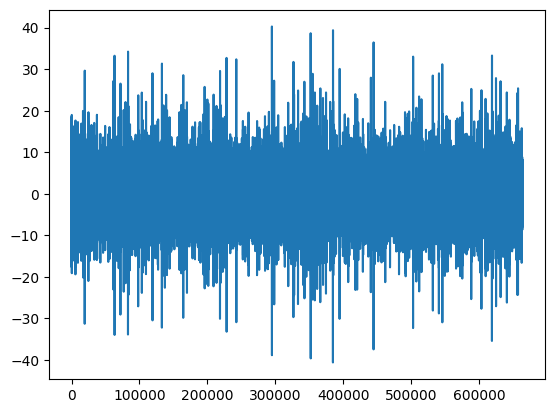

In [9]:
# train_data = SingleDataSystem(['data/water_yifan/2'], ['coord', 'box', 'force', 'energy'])
# import matplotlib.pyplot as plt
# plt.plot(train_data.data['force'].flatten())

In [2]:
import numpy as np
# path = 'data_ex6'
box = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/2/set.000/box.npy').min(axis=0)
# natoms = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path + '/set.000/coord.npy').shape[1] // 3
print(box) 
# print(natoms)

[14.659093  0.        0.        0.       13.902575  0.        0.
  0.        8.470338]


In [6]:
path = '/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/'
paths = [path + '1/']

In [7]:
coord, box, energy, force = [], [], [], []
for path in paths:
    coord.append(np.load(path + '/set.000/coord.npy'))
    force.append(np.load(path + '/set.000/force.npy'))
    box.append(np.load(path + '/set.000/box.npy'))
    energy.append(np.load(path + '/set.000/energy.npy'))
coord = np.concatenate(coord)
box = np.concatenate(box)
energy = np.concatenate(energy)
force = np.concatenate(force)
idx = ((box[:,::4]).min(1) > 12)
# idx = ((box[:,::4]).min(1) > 10)
print(box.shape, coord.shape, energy.shape, force.shape)
box = box[idx]
coord = coord[idx]
energy = energy[idx]
force = force[idx]
print(box.shape, coord.shape, energy.shape, force.shape)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/coord.npy', coord)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/box.npy', box)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/energy.npy', energy)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/force.npy', force)

(1517, 9) (1517, 576) (1517,) (1517, 576)
(1502, 9) (1502, 576) (1502,) (1502, 576)


In [32]:
paths = ['data%d' % i for i in range(1, 46)] + ['data_ex%d' % i for i in range(1, 7)]
paths = ['/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path for path in paths]